# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [203]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 1
key = jax.random.PRNGKey(seed)
sample_key, shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 5)

gamma = 0.95

# Sample collection
state_x_margin = 0.05
state_v_margin = 2.5
n_actions = 2
n_samples = 1000

# Weights collection
n_weights = 50

# Trainings
layers_dimension = (15,)
max_bellman_iterations = 5
batch_size_samples = n_samples

## Linear PBO
training_steps = 100
fitting_steps = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.0005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# Visualisation of errors and performances
n_states_x_visu = 13
n_states_v_visu = 9
margin_visu = 0.01
horizon = 70

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [204]:
from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0
max_pos_margin = max_pos - state_x_margin
max_velocity_margin = max_velocity - state_v_margin
max_pos_margin_visu = max_pos - margin_visu
max_velocity_margin_visu = max_velocity - margin_visu

states_x_visu = jnp.linspace(-max_pos_margin_visu, max_pos_margin_visu, n_states_x_visu)
boxes_x_size = (2 * max_pos_margin_visu) / (n_states_x_visu - 1)
states_x_boxes = (np.linspace(-max_pos_margin_visu, max_pos_margin_visu + boxes_x_size, n_states_x_visu + 1) - boxes_x_size / 2)
states_v_visu = jnp.linspace(-max_velocity_margin_visu, max_velocity_margin_visu, n_states_v_visu)
boxes_v_size = (2 * max_velocity_margin_visu) / (n_states_v_visu - 1)
states_v_boxes = (np.linspace(-max_velocity_margin_visu, max_velocity_margin_visu + boxes_v_size, n_states_v_visu + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [205]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
for idx_sample in range(n_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.uniform(key, (2,), minval=jnp.array([-max_pos_margin, -max_velocity_margin]), maxval=jnp.array([max_pos_margin, max_velocity_margin])))

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"

In [206]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [0],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

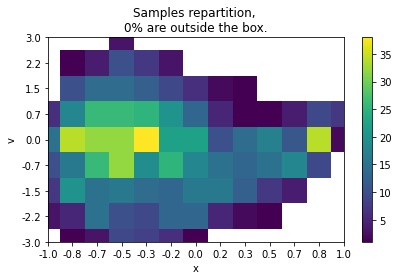

In [207]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

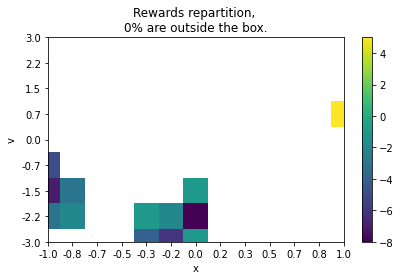

In [208]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train Q with Fitted-Q with enough power to make it working

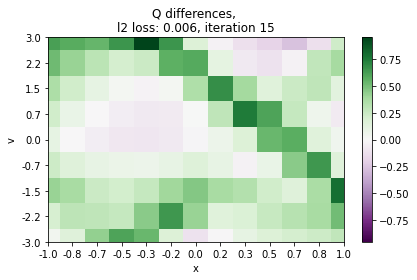

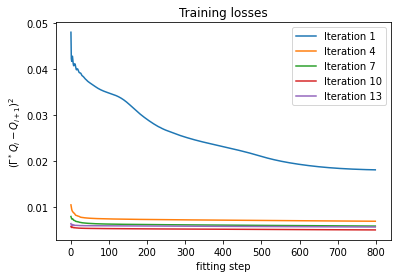

In [209]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_best = 15
fitting_steps_q_best = 800
batch_size_samples = n_samples

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q_best = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_best},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations_best, fitting_steps_q_best)) * np.nan

for bellman_iteration in range(max_bellman_iterations_best):
    params_target = q_best.params

    for step in range(fitting_steps_q_best):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q_best.params, q_best.optimizer_state, l2_loss = q_best.learn_on_batch(q_best.params, params_target, q_best.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")


for bellman_iteration in range(0, max_bellman_iterations_best, max_bellman_iterations_best // 5):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

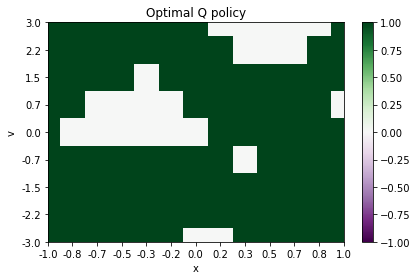

In [210]:
best_diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

q_visu_mesh.set_values((best_diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

In [211]:
env.simulate(q_best, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.36236867]
[0.27689835]

[-0.5196691 -0.3866922]
[0.3748773]
[0.36083123]

[-0.57458174 -0.69058496]
[0.30486408]
[0.3770593]

[-0.6150591  -0.11151298]
[0.37235674]
[0.30936846]

[-0.63391644 -0.25889763]
[0.3706045]
[0.3300856]

[-0.66504884 -0.35312155]
[0.35762295]
[0.33956477]

[-0.7022661 -0.3797459]
[0.34533587]
[0.33654585]

[-0.738847   -0.34224313]
[0.3462222]
[0.33205453]

[-0.76908296 -0.25586426]
[0.3577895]
[0.33342353]

[-0.7889984  -0.13875583]
[0.36683986]
[0.34018192]

[-0.79635036 -0.00705088]
[0.36485657]
[0.34680745]

[-0.7903853   0.12535758]
[0.35417476]
[0.3478919]

[-0.7717115   0.24470766]
[0.34193859]
[0.34176072]

[-0.74240416  0.3351525 ]
[0.33322123]
[0.32992736]

[-0.7062485   0.37862065]
[0.3300285]
[0.3154663]

[-0.66878945  0.3591725 ]
[0.33352473]
[0.30232075]

[-0.63670284  0.2716893 ]
[0.34405485]
[0.29394564]

[-0.61632055  0.12869465]
[0.35826334]
[0.2923039]

[-0.61187553 -0.04139954]
[0.3697264]
[0.30162284]

[-0.62430596 -0.202735

DeviceArray([False], dtype=bool)

## Train Q with Fitted-Q

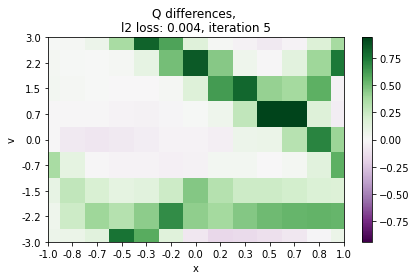

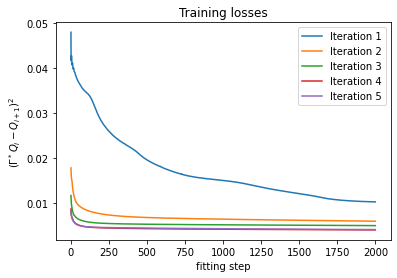

In [212]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

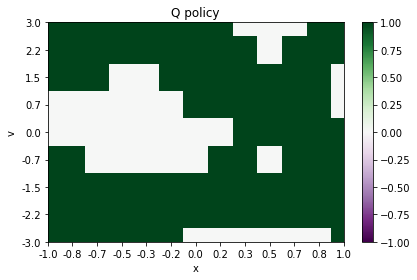

In [213]:
diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q policy", xlabel="x", ylabel="v")

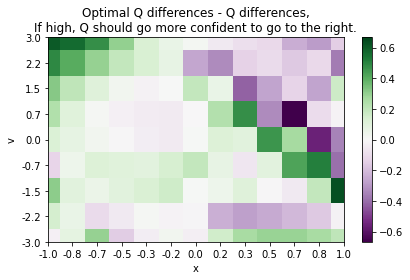

In [214]:
q_visu_mesh.set_values(best_diff_q - diff_q)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.", xlabel="x", ylabel="v")

In [215]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.10355414]
[0.02583715]

[-0.5196691 -0.3866922]
[0.13224143]
[0.03286924]

[-0.57458174 -0.69058496]
[0.13481438]
[0.08952466]

[-0.6524237  -0.83584255]
[0.10953388]
[0.12443577]

[-0.7017524  -0.14994894]
[0.12496463]
[0.02079292]

[-0.716432   -0.13959952]
[0.1247256]
[0.02250193]

[-0.72893536 -0.1072372 ]
[0.12166757]
[0.02273592]

[-0.73734564 -0.05890802]
[0.11613735]
[0.02142182]

[-0.74043596 -0.00216452]
[0.10858206]
[0.01879878]

[-0.7377684   0.05488331]
[0.09990077]
[0.01547194]

[-0.7297206   0.10410859]
[0.09156349]
[0.01230603]

[-0.71746296  0.13789132]
[0.08526043]
[0.01005299]

[-0.7028669   0.15002899]
[0.08231277]
[0.00899303]

[-0.6882964   0.13713518]
[0.08326449]
[0.00890243]

[-0.6762506  0.100092 ]
[0.08787971]
[0.00937904]

[-0.668894    0.04471355]
[0.09534089]
[0.01024259]

[-0.6675892  -0.01903605]
[0.10436936]
[0.01168318]

[-0.67258096 -0.07920866]
[0.11327402]
[0.01397622]

[-0.6829379  -0.12470978]
[0.12031458]
[0.0169702]

[-0.6967719 -

DeviceArray([False], dtype=bool)

## Collect weights

In [216]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

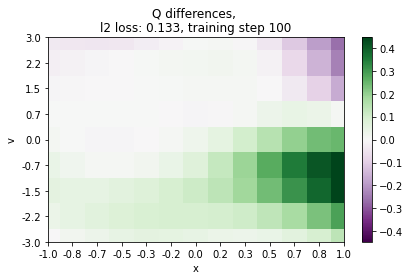

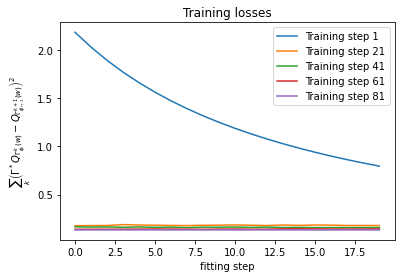

In [217]:
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, True, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.zeros(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    if training_step // 20 <= max_bellman_iterations:
        importance_iteration = jnp.linspace(max_bellman_iterations, training_step // 20 + 1, max_bellman_iterations + 1)
    print(importance_iteration)
    params_target = pbo.params

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    if (training_step + 1) % 5 == 0:
        q_weight = pbo.fixed_point(pbo.params)
        q_pbo.params = q_pbo.to_params(q_weight)
        diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

        q_visu_mesh.set_values(diff_q_pbo)
        q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, max(training_steps // 5, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

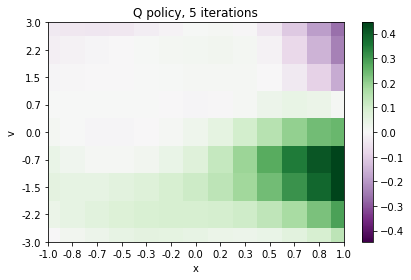

In [218]:
test_bellman_iterations = max_bellman_iterations

q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))

diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(diff_q_pbo)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

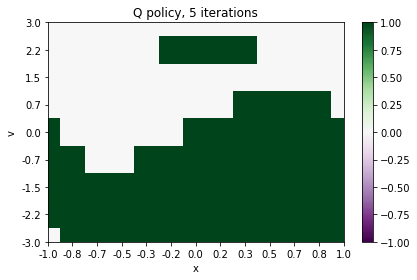

In [219]:
q_visu_mesh.set_values((diff_q_pbo > 0.01).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [220]:
env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))


[-0.5  0. ]
[-0.5185073]
[-0.52714]

[-0.5196691 -0.3866922]
[-0.5317584]
[-0.5385511]

[-0.57458174 -0.69058496]
[-0.57230103]
[-0.5677016]

[-0.6150591  -0.11151298]
[-0.545755]
[-0.5544254]

[-0.63391644 -0.25889763]
[-0.5600553]
[-0.5673346]

[-0.66504884 -0.35312155]
[-0.58166796]
[-0.5861554]

[-0.7022661 -0.3797459]
[-0.60545087]
[-0.6073511]

[-0.738847   -0.34224313]
[-0.6261013]
[-0.626457]

[-0.76908296 -0.25586426]
[-0.63980526]
[-0.63966775]

[-0.7585317   0.46840566]
[-0.60816306]
[-0.6093589]

[-0.70769835  0.5356181 ]
[-0.5848841]
[-0.5859703]

[-0.6544083   0.51335937]
[-0.5630109]
[-0.5644125]

[-0.6084811   0.38862753]
[-0.54445165]
[-0.54764986]

[-0.5795092   0.18001454]
[-0.5323157]
[-0.5389095]

[-0.5737971  -0.06788766]
[-0.53141075]
[-0.5406693]

[-0.5925907 -0.3009962]
[-0.54587835]
[-0.553755]

[-0.6317891  -0.46848726]
[-0.57417375]
[-0.5771812]

[-0.6829808 -0.5379216]
[-0.6087416]
[-0.6071323]

[-0.7024054   0.14900568]
[-0.57887715]
[-0.5837694]

[-0.6879

DeviceArray([False], dtype=bool)